# [Modu-DS5기] Credit Card Fraud Detection

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
1. `xgboost` : 3.0.4
2. `lightgbm` : 4.6.0

### 기타 사용 라이브러리
1. `hyperopt`


In [1]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 3.0.4
Uninstalling xgboost-3.0.4:
  Successfully uninstalled xgboost-3.0.4
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [2]:
!pip install xgboost==3.0.4 lightgbm==4.6.0

  Using cached xgboost-3.0.4-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached xgboost-3.0.4-py3-none-win_amd64.whl (56.8 MB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)

   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   ---------------------------------------- 0/2 [xgboost]
   -------------------- ------------------- 1/2 [lightgbm]
   ---------------------------------------- 2/2 [lightgbm]




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install hyperopt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
for dirname, _, filenames in os.walk('./modulabs-ds5-credit-card-fraud-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./modulabs-ds5-credit-card-fraud-detection\sample_submission.csv
./modulabs-ds5-credit-card-fraud-detection\test.csv
./modulabs-ds5-credit-card-fraud-detection\train.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/train.csv')
test_df = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/test.csv')

In [6]:
warnings.filterwarnings('ignore')

train_df = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/train.csv')
test_df = pd.read_csv('./modulabs-ds5-credit-card-fraud-detection/test.csv')

# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

# 데이터 확인

In [7]:
train_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


# 데이터 전처리  

V(n)의 경우 PCA 값으로 전처리가 어려우므로, Amount와 time 변수 feature enginnering 진행 

## id

In [9]:
# 단순 식별자이므로 drop
train_df.drop('id', axis=1, inplace=True)

## Amount

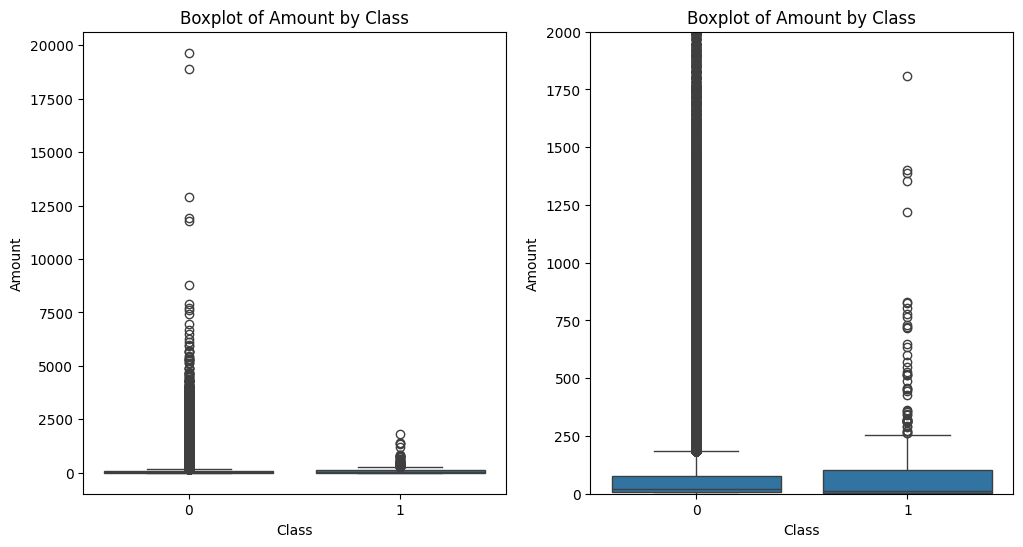

In [10]:
# 시각화 - boxplot (Amount)

plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
sns.boxplot(x = 'Class', y = 'Amount', data = train_df)
plt.title('Boxplot of Amount by Class')
plt.tight_layout

plt.subplot(1, 2, 2)
sns.boxplot(x = 'Class', y = 'Amount', data = train_df)
plt.title('Boxplot of Amount by Class')
plt.tight_layout
plt.ylim(0, 2000)


plt.show()


In [11]:
# class = 1 (fraud) 인 값의 Amount는 최대 2000 정도로, 이 이상의 값은 극단치로서 작용할 가능성 높아보임.
# Amount >= 2000 drop 하여 극단치 제거.
# Amount < 2000 밑은 log 변환하여 분포 확인에 용이하도록 진행.

train_df = train_df[train_df['Amount'] < 2000]
train_df['Amount_log'] = np.log1p(train_df['Amount'])

train_df.drop('Amount', axis=1, inplace=True)

In [12]:
# log를 통해 amount 값이 작아지고 분산이 작아짐을 확인
train_df['Amount_log'].describe()

count    170481.000000
mean          3.130791
std           1.641120
min           0.000000
25%           1.862529
50%           3.116622
75%           4.343805
max           7.600402
Name: Amount_log, dtype: float64

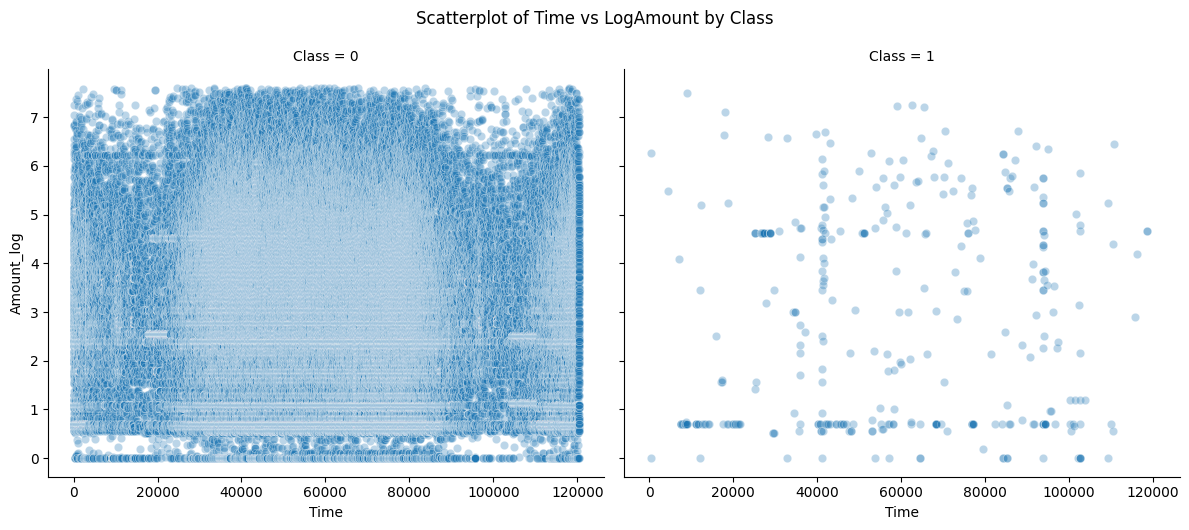

In [13]:
# log amount & time 시각화
# time의 값이 0~120000 으로 표기되어 있어 모델링에 부적합해보임 > hour 단위로 변환
# amount_log 값이 작은 곳에서, time = 40000 및 100000 에서 fraud 가 많아 보임.

g = sns.FacetGrid(train_df, col="Class", height=5, aspect=1.2)
g.map(sns.scatterplot, "Time", "Amount_log", alpha=0.3)
g.fig.suptitle("Scatterplot of Time vs LogAmount by Class", y=1.05)
plt.show()


## Time

In [14]:
# 누적 초 단위로 표기되어 있으므로 산수를 통해 hour 단위로 변경
# hour = 1 은 1:00 가 아닌 1시간이 지남 임을 주의
train_df['Hour'] = ((train_df['Time'] // 3600)).astype(int)
train_df['Hour'].value_counts()

# Time 제거
train_df.drop('Time', axis=1, inplace=True)


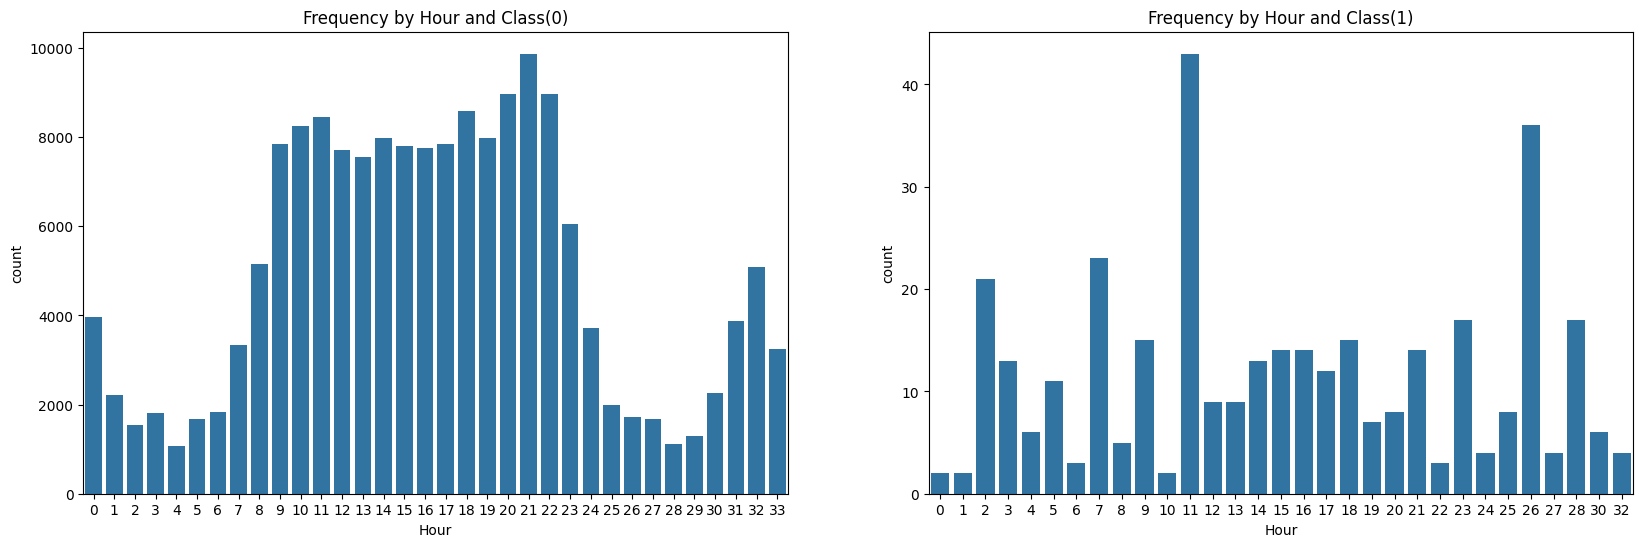

In [15]:
# time 시각화
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.countplot(x = 'Hour', data = train_df[train_df['Class'] == 0])
plt.title('Frequency by Hour and Class(0)')
plt.tight_layout

plt.subplot(1, 2, 2)
sns.countplot(x = 'Hour', data = train_df[train_df['Class'] == 1])
plt.title('Frequency by Hour and Class(1)')
plt.tight_layout

plt.show()

In [16]:
# fraud 빈도 확인
fraud = train_df[train_df['Class'] == 1].shape[0]
total = train_df.shape[0]
fraud / total

# 0.0021116722684639344 (약 0.211%) 로 매우 낮음 > Oversampling 필요

0.0021116722684639344

## SMOTE

In [17]:
# fraud data가 너무 적어 SMOTE 통해 oversampling 진행
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

X = train_df.drop('Class', axis = 1)
y = train_df['Class']

# train, test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42 
)

# SMOTE
smote = SMOTE(random_state = 42)        # sampling_strategy = 1
X_train_smo, y_train_smo = smote.fit_resample(X_train, y_train)

print('Before SMOTE: ', y_train.value_counts())
print('After SMOTE: ', y_train_smo.value_counts())

Before SMOTE:  Class
0    136097
1       287
Name: count, dtype: int64
After SMOTE:  Class
0    136097
1    136097
Name: count, dtype: int64


# 모델 정의

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),  
    "RandomForest": RandomForestClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False)
}

results = []

for name, model in models.items():
    print(f'====== {name} ======')
    model.fit(X_train_smo, y_train_smo)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results.append((name, f1))
    print('\nF1 Score: ', f1)
    print(classification_report(y_test, y_pred))
    print()

# 결과 요약
print('모델별 F1 Score: ')
for name, f1 in results:
    print(f'{name}: {f1:.4f}')

# LogisticRegression: 0.1512 > 선형분류로 진행하다 보니 recall은 높으나 precision이 매우 떨어짐
# RandomForest: 0.8777 > 비교 후 하이퍼파라미터 튜닝 진행
# LightGBM: 0.8212
# XGBoost: 0.8649 > 하이퍼파라미터 튜닝 진행

====== LogisticRegression ======

F1 Score:  0.15124153498871332
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34024
           1       0.08      0.92      0.15        73

    accuracy                           0.98     34097
   macro avg       0.54      0.95      0.57     34097
weighted avg       1.00      0.98      0.99     34097


====== RandomForest ======

F1 Score:  0.8776978417266187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34024
           1       0.92      0.84      0.88        73

    accuracy                           1.00     34097
   macro avg       0.96      0.92      0.94     34097
weighted avg       1.00      1.00      1.00     34097


====== LightGBM ======
[LightGBM] [Info] Number of positive: 136097, number of negative: 136097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010313 seconds.
You can set `force_co

# 학습 

In [19]:
# XGBoost 하이퍼파라미터 튜닝
from hyperopt import hp

xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 3, 6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.1)
}

In [20]:
# 목적 함수 생성
# 3 Fold 교차 검증 이용해 f1_score 반환
from sklearn.model_selection import KFold

def objective_func(search_space):
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=int(search_space['max_depth']),
        min_child_weight=int(search_space['min_child_weight']),
        gamma=search_space['gamma'],
        colsample_bytree=search_space['colsample_bytree'],
        subsample=search_space['subsample'],
        learning_rate=search_space['learning_rate'],
        random_state=42
    )

    f1_list = []

    # 3 k-fold
    kf = KFold(n_splits=3, shuffle=True, random_state=42)   # 일부 hour 구간에 fraud 쏠림 방지

    for tr_index, val_index in kf.split(X_train_smo, y_train_smo):
        X_tr, y_tr = X_train_smo.iloc[tr_index], y_train_smo.iloc[tr_index]
        X_val, y_val = X_train_smo.iloc[val_index], y_train_smo.iloc[val_index]

        # 모델 학습
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        # F1 score 계산
        y_pred = xgb_clf.predict(X_val)
        score = f1_score(y_val, y_pred)

        f1_list.append(score)

    # Hyperopt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(f1_list)

In [ ]:
# fmin 함수 호출
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
    fn = objective_func,
    space = xgb_search_space,
    algo = tpe.suggest,
    max_evals = 50, 
    trials = trials, 
    rstate = np.random.default_rng(seed = 42)
    )

print('best: ', best)

# best:  {
#     'colsample_bytree': 0.922708653325232, 
#     'gamma': 0.3080110083893033, 
#     'learning_rate': 0.09223157486935152, 
#     'max_depth': 6.0, 
#     'min_child_weight': 1.0, 
#     'subsample': 0.7410668198342454
#     }

100%|██████████| 50/50 [02:04<00:00,  2.50s/trial, best loss: -0.9989943765101907]
best:  {'colsample_bytree': 0.922708653325232, 'gamma': 0.3080110083893033, 'learning_rate': 0.09223157486935152, 'max_depth': 6.0, 'min_child_weight': 1.0, 'subsample': 0.7410668198342454}


# 예측 및 평가

In [ ]:
# n_estimators 증가 및 최적 파라미터 적용
xgb_clf = xgb.XGBClassifier(
    n_estimators = 1000,
    colsample_bytree = round(best['colsample_bytree'], 5),
    gamma = round(best['gamma'], 5),
    learning_rate = round(best['learning_rate'], 5),
    max_depth = int(best['max_depth']),
    min_child_weight = int(best['min_child_weight']),
    subsample = round(best['subsample'], 5),
    early_stopping_rounds = 100
    )

# 학습 
xgb_clf.fit(
    X_train_smo, y_train_smo, 
    eval_set = [(X_test, y_test)], 
    verbose=True
    )

# 평가
y_pred = xgb_clf.predict(X_test)
xgb_f1_score = f1_score(y_test, y_pred)

print('F1 Score: {0:.4f}'.format(xgb_f1_score))

print(f'\nclassification_report:\n ', classification_report(y_test, y_pred))

# F1 Score: 0.8533

[0]	validation_0-logloss:0.61257
[1]	validation_0-logloss:0.54605
[2]	validation_0-logloss:0.48942
[3]	validation_0-logloss:0.44034
[4]	validation_0-logloss:0.39799
[5]	validation_0-logloss:0.36100
[6]	validation_0-logloss:0.32854
[7]	validation_0-logloss:0.29983
[8]	validation_0-logloss:0.27426
[9]	validation_0-logloss:0.25159
[10]	validation_0-logloss:0.23148
[11]	validation_0-logloss:0.21340
[12]	validation_0-logloss:0.19701
[13]	validation_0-logloss:0.18219
[14]	validation_0-logloss:0.16901
[15]	validation_0-logloss:0.15704
[16]	validation_0-logloss:0.14606
[17]	validation_0-logloss:0.13597
[18]	validation_0-logloss:0.12657
[19]	validation_0-logloss:0.11841
[20]	validation_0-logloss:0.11101
[21]	validation_0-logloss:0.10421
[22]	validation_0-logloss:0.09802
[23]	validation_0-logloss:0.09232
[24]	validation_0-logloss:0.08687
[25]	validation_0-logloss:0.08203
[26]	validation_0-logloss:0.07762
[27]	validation_0-logloss:0.07356
[28]	validation_0-logloss:0.06983
[29]	validation_0-loglos

In [ ]:
# threshold 최적화

y_proba = xgb_clf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"\nBest threshold: {best_t:.2f}")
print(f"Best F1 Score (with threshold tuning): {best_f1:.4f}")

y_pred_opt = (y_proba >= best_t).astype(int)
print("\nclassification_report with tuned threshold:\n",
      classification_report(y_test, y_pred_opt))

# F1 Score (with threshold tuning): 0.8936


Best threshold: 0.86
Best F1 Score (with threshold tuning): 0.8936

classification_report with tuned threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34024
           1       0.93      0.86      0.89        73

    accuracy                           1.00     34097
   macro avg       0.96      0.93      0.95     34097
weighted avg       1.00      1.00      1.00     34097



In [24]:
# test_df 확인
test_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [25]:
# 전처리
test_df['Amount_log'] = np.log1p(test_df['Amount'])
test_df.drop('Amount', axis = 1, inplace = True)

test_df['Hour'] = ((test_df['Time'] // 3600)).astype(int)
test_df.drop('Time', axis = 1, inplace = True)

test_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log,Hour
0,170883,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,-2.277774,...,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,4.836123,33
1,170884,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,0.529802,...,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,3.931826,33
2,170885,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,-0.648266,...,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,2.271094,33
3,170886,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,-0.041604,...,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,4.110710,33
4,170887,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,-0.634128,...,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,4.795543,33


In [26]:
# 예측 (확률)
X_test_features = test_df.drop("id", axis=1)
test_proba = xgb_clf.predict_proba(X_test_features)[:, 1]

# 최적 threshold 적용
xgb_pre = (test_proba >= best_t).astype(int)

# 제출용 DataFrame
submission = pd.DataFrame({
    "id": test_df["id"],
    "Class": xgb_pre
})

# csv 파일 저장
submission.to_csv("submission.csv", index=False)